In [96]:
# download a few sample pkl files
from tqdm import tqdm
import urllib.request
import os
import pandas as pd

pkl_path = 'evaluation_results'
t_start = '20240509T120000' # minimum date is: 20240505T000000
t_end = '20240510T000000' # maximum date is: 20240511T043600
cadence = '12min' # max cadence is 12min --> HMI cadence
os.makedirs(pkl_path, exist_ok=True)

for date in tqdm(pd.date_range(t_start, t_end, freq=cadence), desc='Downloading pkl files'):
    date_str = date.strftime('%Y%m%d_%H%M%S_TAI')
    pkl_url = f'https://g-66affc.7a577b.6fbd.data.globus.org/evaluation/pkl/{date_str}.pkl'
    save_path = os.path.join(pkl_path, f'{date_str}.pkl')
    if os.path.exists(save_path):
        print(f"File {save_path} already exists, skipping")
        continue
    try:
        urllib.request.urlretrieve(pkl_url, save_path)
    except:
        print(f"Failed to download {pkl_url}")

In [103]:
from nf2.evaluation.sharp.convert_series import load_results
import numpy as np

output = load_results(os.path.join(pkl_path, '*.pkl'))

Loading files: 100%|██████████| 6/6 [00:00<00:00, 469.67it/s]


In [104]:
# print all keys and subkeys
def print_keys(output):
    for key in output.keys():
        if isinstance(output[key], dict):
            print(f"{key:<20}{list(output[key].keys())}")
        elif isinstance(output[key], np.ndarray):
            print(f"{key:<20}{output[key].shape}")
        elif isinstance(output[key], float):
            print(f"{key:<20}{output[key]:.2f}")
        else:
            print(f"{key:<20}")

print(f"{'Keys':<20}{'Values':<20}")
print(f"{'-'*20}{'-'*20}")
print_keys(output)

print('\n\n')
print('Integrated quantities:')
print(f"{'Keys':<20}{'Values':<20}")
print(f"{'-'*20}{'-'*20}")
print_keys(output['integrated_quantities'])

print('\n\n')
print('maps:')
print(f"{'Keys':<20}{'Values':<20}")
print(f"{'-'*20}{'-'*20}")
print_keys(output['maps'])


Keys                Values              
----------------------------------------
times               (6,)
integrated_quantities['energy', 'free_energy']
metrics             ['divergence', 'jxb', 'theta']
maps                ['b_0', 'current_density_map', 'energy_map', 'free_energy_map', 'jxb_map']
height_distribution ['height_free_energy', 'height_current_density']
wcs                 (6, 1)
Mm_per_pixel        0.72



Integrated quantities:
Keys                Values              
----------------------------------------
energy              (6,)
free_energy         (6,)



maps:
Keys                Values              
----------------------------------------
b_0                 (6, 601, 257)
current_density_map (6, 601, 257)
energy_map          (6, 601, 257)
free_energy_map     (6, 601, 257)
jxb_map             (6, 601, 257)


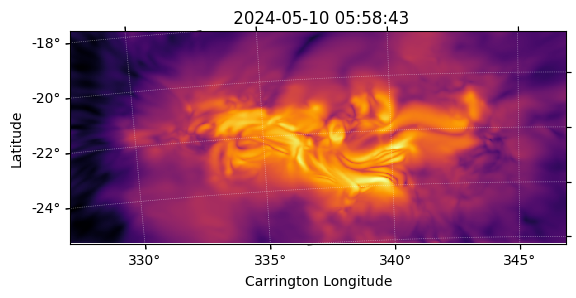

In [105]:
# load current map as SunPy map
from sunpy.map import Map

idx = 0
wcs = output['wcs'][idx, 0]
data = output['maps']['current_density_map'][idx]

map = Map(data.T, wcs)
map.plot(cmap='inferno', norm='log')

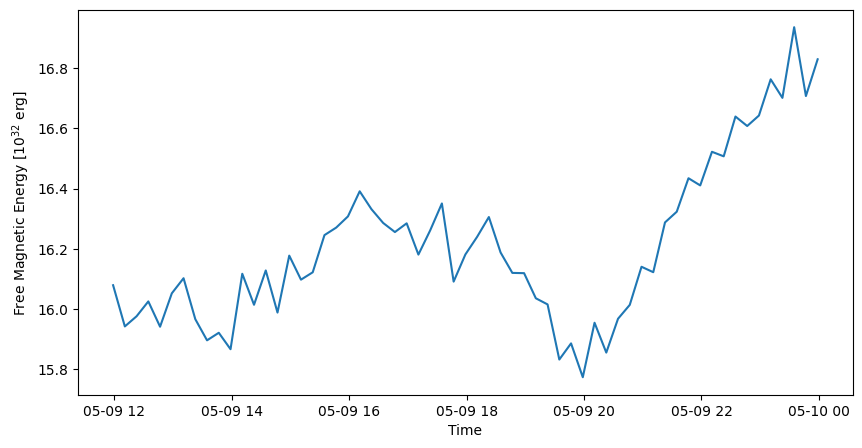

In [36]:
# plot free energy evolution
import matplotlib.pyplot as plt
from astropy import units as u

fig, ax = plt.subplots(figsize=(10, 5))

ax.xaxis_date()
ax.plot(output['times'], output['integrated_quantities']['free_energy'].to_value(u.erg) * 1e-32)
ax.set_xlabel('Time')
ax.set_ylabel('Free Magnetic Energy [$10^{32}$ erg]')
plt.show()